# Decoding Hand Movements from Latent EEG Representations with Reduced Channels

Name: Giedrius Mirklys

Student #: s1101773

Data downloaded from `https://www.kaggle.com/competitions/grasp-and-lift-eeg-detection/data`

Data processing and model architecture are inspired by `https://www.kaggle.com/code/aarajbhattarai/gesture-recognition`


# Install the required packages

In [ ]:
%pip install nvidia-cudnn-cu12
%pip install --upgrade flax jax jaxlib

# Connect to Google Drive

In [ ]:
# connect to gdrive
from google.colab import drive

drive.mount("/content/drive")

In [ ]:
ROOT_PATH = "/content/drive/MyDrive/Projects/neural encodings"

# Import the packages

In [ ]:
import os
from collections import OrderedDict, defaultdict
from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import torch as th
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from flax import linen as nn
from flax.training import train_state
import jax
from jax.nn.initializers import glorot_uniform
import jax.numpy as jnp
import optax
import orbax.checkpoint as ocp

In [ ]:
jax.config.update("jax_platform_name", "gpu")

In [ ]:
plt.style.use("seaborn-v0_8-paper")

# Process and visualize data

Raw data is stored in:
- `eeg_signals`, list
- `gestures`, list

In [ ]:
# unzip data
# run it once to avoid unzipping multiple times

FILE_PATH = ROOT_PATH + "/data"
list_dir = os.listdir(FILE_PATH)

for zipfile in list_dir:
    if zipfile.endswith(".zip"):
        with ZipFile(os.path.join(FILE_PATH, zipfile), "r") as z:
            z.extractall(path=FILE_PATH)
            for filename in z.namelist():
                if filename.endswith(".zip"):
                    print(f"Extracted: {filename}")
                    with ZipFile(os.path.join(FILE_PATH, filename), "r") as inner_zip:
                        inner_zip.extractall(path=FILE_PATH)
                        print(f"Extracted: {filename}")

In [ ]:
TRAIN_PATH = f"{ROOT_PATH}/data/train"

In [ ]:
def read_csv(data_path, events_path):
    data = pd.read_csv(data_path)
    events = pd.read_csv(events_path)

    data = data.iloc[:, 1:].values  # removes the id column
    events = events.iloc[:, 1:].values  # removes the id column

    return data, events

In [ ]:
eeg_signals = []
gestures = []
data_files = [p for p in os.listdir(TRAIN_PATH) if p.endswith("data.csv")]

for data_file in tqdm(data_files):
    id = data_file.split(".")[0].replace("_data", "")
    event_file = f"{id}_events.csv"

    data_file_path = os.path.join(TRAIN_PATH, data_file)
    events_file_path = os.path.join(TRAIN_PATH, event_file)

    data, events = read_csv(data_file_path, events_file_path)

    eeg_signals.append(data.T.astype(np.float32))
    gestures.append(events.T.astype(np.float32))

100%|██████████| 85/85 [02:12<00:00,  1.56s/it]


# Create Dataset

In [ ]:
THRSH = 0.01  # hand movement activity threshold

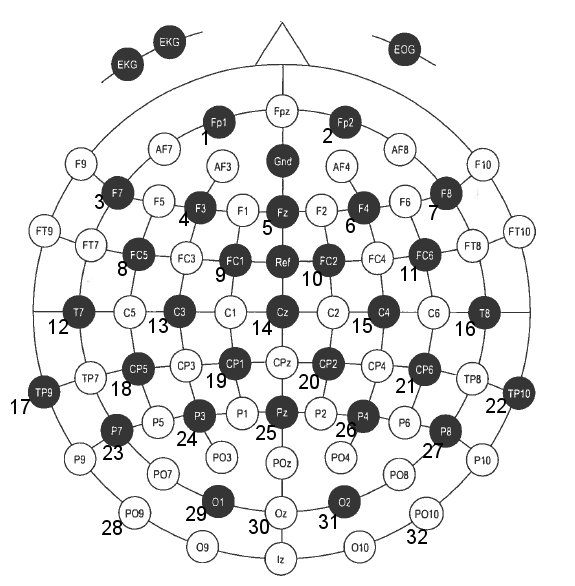

In [ ]:
# check the image above
electrode_map = {
    "Fp1": 0,
    "Fp2": 1,
    "F7": 2,
    "F3": 3,
    "Fz": 4,
    "F4": 5,
    "F8": 6,
    "FC5": 7,
    "FC1": 8,
    "FC2": 9,
    "FC6": 10,
    "T7": 11,
    "C3": 12,
    "Cz": 13,
    "C4": 14,
    "T8": 15,
    "TP9": 16,
    "CP5": 17,
    "CP1": 18,
    "CP2": 19,
    "CP6": 20,
    "TP10": 21,
    "P7": 22,
    "P3": 23,
    "Pz": 24,
    "P4": 25,
    "P8": 26,
    "PO9": 27,
    "O1": 28,
    "Oz": 29,
    "O2": 30,
    "PO10": 31,
}

In [ ]:
class EEGSignalDataset(Dataset):
    def __init__(self, data, gestures, chunk_size=2**9, threshold=THRSH):
        self.data = data
        self.gestures = gestures
        self.eps = 1e-7
        self.chunk_size = chunk_size
        self.remove_channels = []
        self.threshold = threshold

        self.index = self._create_index(chunk_size)
        self._normalize_data()

    def _create_index(self, chunk_size):
        """Create an index of (i, start, end) tuples for each chunk of data.

        The data is flattened at the participant level, resulting in a list
        of tuples containing the participant index and the start and end indices
        of signal chunks where the activity was above a predefined threshold.
        """
        return [
            (i, start, end)
            for i, gesture_indices in enumerate(self._get_sample_indices(chunk_size))
            for start, end in gesture_indices
        ]

    def _get_sample_indices(self, chunk_size):
        """Get the start and end indices of signal chunks
        where the activation is above the threshold.
        """
        sample_indices = []
        for gesture in self.gestures:  # loops through each participant
            gesture_indices = []
            num_chunks = gesture.shape[1] // chunk_size + (
                1 if gesture.shape[1] % chunk_size != 0 else 0
            )
            for j in range(num_chunks):
                start_idx = j * chunk_size
                end_idx = min(gesture.shape[1], (j + 1) * chunk_size)
                chunk_mean = np.mean(gesture[:, start_idx:end_idx])
                if chunk_mean >= self.threshold:
                    gesture_indices.append((start_idx, end_idx))
            sample_indices.append(gesture_indices)
        return sample_indices

    def _normalize_data(self):
        _data = np.concatenate(self.data, axis=1)
        mean = np.mean(_data, axis=1, keepdims=True)
        std = np.std(_data, axis=1, keepdims=True)

        for dt in self.data:
            dt -= mean
            dt /= std + self.eps

    def __getitem__(self, idx):
        """Get a single item from the dataset.

        Returns:
            - Tuple (raw_data, one_hot_label).
        """
        i, start, end = self.index[idx]
        raw_data = np.array(self.data[i])[:, start:end]  # Shape: (32, chunk_size)
        label = np.array(self.gestures[i])[:, start:end]  # Shape: (6, chunk_size)

        label = np.argmax(label.sum(axis=1))  # one hand movement per chunk

        pad = self.chunk_size - raw_data.shape[1]  # making lengths of chunks equal
        if pad > 0:
            raw_data = np.pad(
                raw_data, ((0, 0), (0, pad)), "constant", constant_values=0
            )

        if self.remove_channels:
            electrode_indices = [
                electrode_map[channel] for channel in self.remove_channels
            ]
            raw_data[electrode_indices, :] = 0.0

        raw_data = raw_data.T  # Shape: (chunk_size, 32)

        # Convert to tensors
        raw_data = th.from_numpy(raw_data.astype(np.float32))

        # One-hot encode the label
        one_hot_label = np.zeros(6)
        one_hot_label[label] = 1
        one_hot_label = th.from_numpy(one_hot_label.astype(np.float32))

        return raw_data, one_hot_label

    def add_remove_channels(self, channels):
        self.remove_channels = channels

    def __len__(self):
        return len(self.index)

## Create training and validation datasets

In [ ]:
# Data split
train_eeg = eeg_signals[:-2]
train_gestures = gestures[:-2]

valid_eeg = eeg_signals[-2:]
valid_gestures = gestures[-2:]

In [ ]:
batch_size = 64

In [ ]:
dataset = EEGSignalDataset(train_eeg, train_gestures)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
valid_dataset = EEGSignalDataset(valid_eeg, valid_gestures)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

### Visualize a sample channel

In [ ]:
batch = next(iter(dataloader))
raw_data, label = batch

In [ ]:
class_labels = [
    "HandStart",
    "FirstDigitTouch",
    "BothStartLoadPhase",
    "LiftOff",
    "Replace",
    "BothReleased",
]

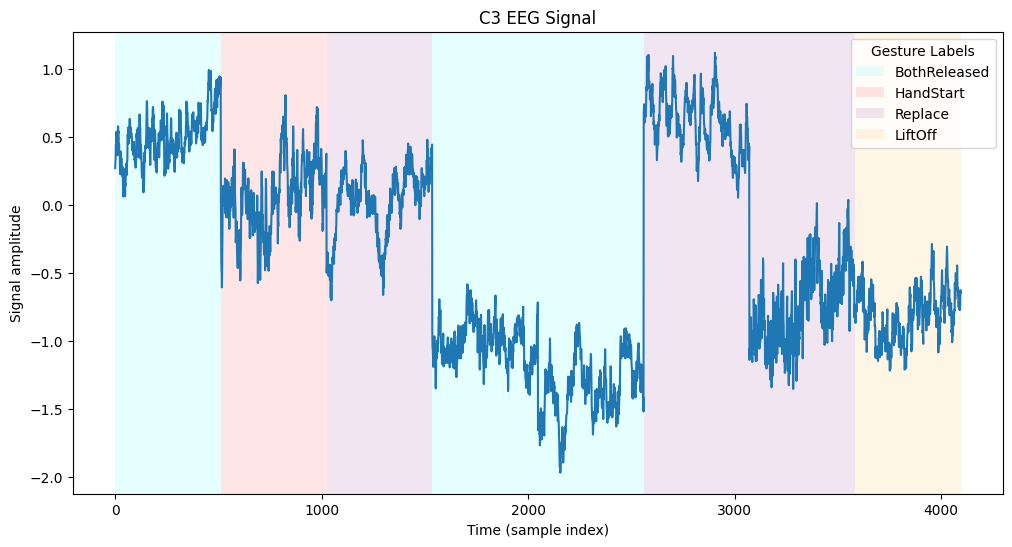

In [ ]:
X_concat = raw_data[:8, :].view(-1, 32)  # Flatten batch*chunk_size
gestures = th.argmax(label[:8, :], dim=1)  # Shape [batch_size]

time_axis = np.arange(X_concat.shape[0])

fig, ax = plt.subplots(figsize=(12, 6))

channel_idx = 12  # channel C3
ax.plot(time_axis, X_concat[:, channel_idx].numpy())

chunk_length = 512
y_min, y_max = ax.get_ylim()
rectangle_height = y_max - y_min

colors = ["red", "green", "blue", "orange", "purple", "cyan"]

handles = OrderedDict()

for i in range(8):  # an arbitrary number of movements to display
    gesture_label = gestures[i].item()
    rect_x = i * chunk_length

    # a semi-transparent rectangle with label
    rect = Rectangle(
        (rect_x, y_min),
        chunk_length,
        rectangle_height,
        facecolor=colors[gesture_label],
        alpha=0.1,
        label=class_labels[gesture_label],
    )
    ax.add_patch(rect)

    # unique labels and handles for the legend
    if class_labels[gesture_label] not in handles:
        handles[class_labels[gesture_label]] = rect


ax.legend(handles.values(), handles.keys(), title="Gesture Labels", loc="upper right")

ax.set_xlabel("Time (sample index)")
ax.set_ylabel("Signal amplitude")
ax.set_title("C3 EEG Signal")
plt.show()

### Visualize the balance of datasets

In [ ]:
def check_data_balance(dataset):
    class_counts = [0] * 6
    for _, label in dataset:
        class_index = th.argmax(label).item()
        class_counts[class_index] += 1
    return class_counts

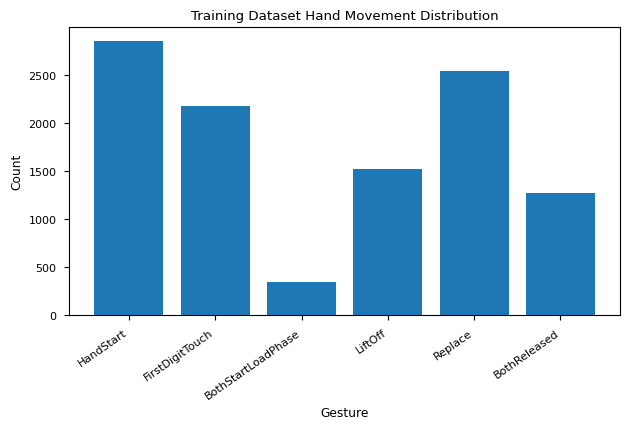

In [ ]:
# Training data balance

class_counts = check_data_balance(dataset)

plt.bar(class_labels, class_counts)
plt.xlabel("Gesture")
plt.ylabel("Count")
plt.title("Training Dataset Hand Movement Distribution")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

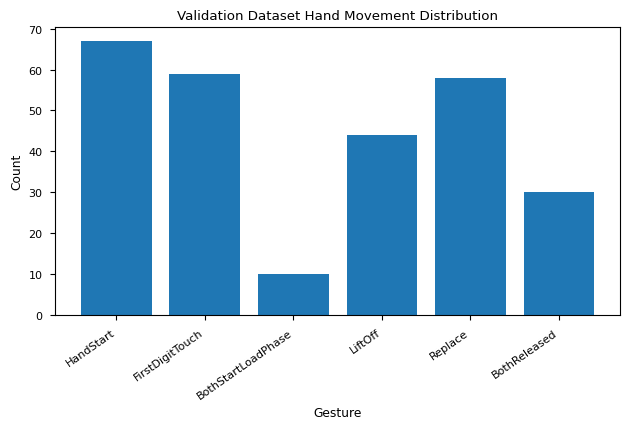

In [ ]:
# Validation data balance

class_counts = check_data_balance(valid_dataset)

plt.bar(class_labels, class_counts)
plt.xlabel("Gesture")
plt.ylabel("Count")
plt.title("Validation Dataset Hand Movement Distribution")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

# Build an encoder-decoder

In [ ]:
class Encoder(nn.Module):
    in_channels: int
    hidden_channels: int

    @nn.compact
    def __call__(self, x, training: bool = True):
        x = nn.Conv(features=self.in_channels, kernel_size=(5,), padding=((2, 2),))(x)
        x = nn.leaky_relu(x, negative_slope=0.1)

        x = nn.Conv(
            features=self.hidden_channels,
            kernel_size=(16,),
            strides=(16,),
            padding="VALID",
            kernel_init=glorot_uniform(),
        )(x)
        x = nn.leaky_relu(x, negative_slope=0.1)

        x = nn.Conv(
            features=self.hidden_channels,
            kernel_size=(7,),
            padding=((3, 3),),
            kernel_init=glorot_uniform(),
        )(x)
        x = nn.leaky_relu(x, negative_slope=0.1)

        for _ in range(2):
            x = self.__block(x, training)
        return x

    def __block(self, x, training):
        x = nn.max_pool(x, window_shape=(2,), strides=(2,))
        x = nn.Dropout(rate=0.1)(x, deterministic=not training)

        x = nn.Conv(
            features=self.hidden_channels,
            kernel_size=(5,),
            padding=((2, 2),),
            kernel_init=glorot_uniform(),
        )(x)
        x = nn.leaky_relu(x, negative_slope=0.1)

        x = nn.Conv(
            features=self.hidden_channels,
            kernel_size=(5,),
            padding=((2, 2),),
            kernel_init=glorot_uniform(),
        )(x)
        x = nn.leaky_relu(x, negative_slope=0.1)
        return x

In [ ]:
class Decoder(nn.Module):
    out_channels: int
    hidden_channels: int

    @nn.compact
    def __call__(self, x):
        # Global average pooling over time dimension
        x = jnp.mean(x, axis=1)  # Shape: (batch, hidden_channels)

        # Fully connected layer to predict hand movement
        x = nn.Dense(features=self.hidden_channels, kernel_init=glorot_uniform())(x)
        x = nn.Dense(features=self.out_channels, kernel_init=glorot_uniform())(x)

        return x

## Initialize the encoder-decoder

In [ ]:
key = jax.random.PRNGKey(0)

x = jax.random.normal(key, (1, 1024, 32))

encoder = Encoder(in_channels=32, hidden_channels=32)
encoder_params = encoder.init(key, x)

key, dropout_key = jax.random.split(key)

encoded = encoder.apply(encoder_params, x, rngs={"dropout": dropout_key})


decoder = Decoder(out_channels=6, hidden_channels=32)
decoder_params = decoder.init(key, encoded)

# Train the model

## Training params and optimizer

In [ ]:
learning_rate = 0.001
optimizer = optax.adamw(learning_rate=learning_rate, b1=0.5, b2=0.99)

params = {"encoder": encoder_params, "decoder": decoder_params}

state = train_state.TrainState.create(apply_fn=None, params=params, tx=optimizer)

## Helper functions for training

In [ ]:
def compute_loss(predictions, labels):
    loss = optax.softmax_cross_entropy(predictions, labels)
    return jnp.mean(loss)

In [ ]:
def compute_f1_score(predictions, labels):
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    f1 = f1_score(true_classes, predicted_classes, average="weighted")

    return f1

In [ ]:
@jax.jit
def train_step(state, batch, key):
    key, dropout_key = jax.random.split(key)

    def loss_fn(params):
        raw_data, label = batch
        encoded = encoder.apply(
            params["encoder"], raw_data, rngs={"dropout": dropout_key}
        )
        predictions = decoder.apply(params["decoder"], encoded)
        return compute_loss(predictions, label)

    grads = jax.grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, key

## Train the model

In [ ]:
num_epochs = 45
epoch_losses = []
epoch_f1s = []
global_step = 0  # for saving the model

In [ ]:
# to save checkpoints
checkpoint_dir = os.path.join(ROOT_PATH, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
checkpointer = ocp.PyTreeCheckpointer()
options = ocp.CheckpointManagerOptions(save_interval_steps=100)
mngr = ocp.CheckpointManager(
    checkpoint_dir, checkpointers={"model": checkpointer}, options=options
)

In [ ]:
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_f1 = 0
    num_batches = 0

    for batch in tqdm(dataloader):
        raw_data, label = batch
        raw_data = jnp.array(raw_data.numpy())
        label = jnp.array(label.numpy())

        state, key = train_step(state, (raw_data, label), key)

        global_step += 1

        mngr.save(global_step, {"model": state})

        encoder_params = state.params["encoder"]
        decoder_params = state.params["decoder"]

        key, dropout_key = jax.random.split(key)

        encoded = encoder.apply(
            encoder_params, raw_data, training=False, rngs={"dropout": dropout_key}
        )
        predictions = decoder.apply(decoder_params, encoded)

        loss = compute_loss(predictions, label)
        f1 = compute_f1_score(predictions, label)

        epoch_loss += loss
        epoch_f1 += f1
        num_batches += 1

    epoch_loss /= num_batches
    epoch_f1 /= num_batches
    print(f"Epoch {epoch + 1} completed - Loss: {epoch_loss:.4f}, F1: {epoch_f1:.4f}")
    epoch_losses.append(epoch_loss)
    epoch_f1s.append(epoch_f1)

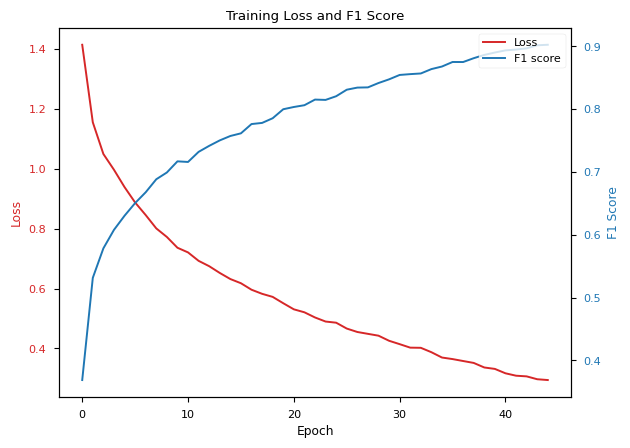

In [ ]:
fig, ax1 = plt.subplots()

# loss on the primary y-axis
color = "tab:red"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color)
ax1.plot(epoch_losses, color=color, label="Loss")
ax1.tick_params(axis="y", labelcolor=color)

# a secondary y-axis for f1 score
ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel("F1 Score", color=color)
ax2.plot(epoch_f1s, color=color, label="F1 score")
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()
plt.title("Training Loss and F1 Score")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()

# Test the model

In [ ]:
@jax.jit
def test_step(state, batch):
    raw_data, label = batch
    encoded = encoder.apply(state.params["encoder"], raw_data, training=False)
    predictions = decoder.apply(state.params["decoder"], encoded)
    return predictions, label

In [ ]:
def evaluate_model(state, valid_dataloader):
    total_loss = 0
    total_f1 = 0
    num_batches = 0

    for batch in valid_dataloader:
        raw_data, label = batch
        raw_data = jnp.array(raw_data.numpy())  # Convert to JAX arrays
        label = jnp.array(label.numpy())

        predictions, true_labels = test_step(state, (raw_data, label))
        loss = compute_loss(predictions, true_labels)
        f1 = compute_f1_score(predictions, true_labels)
        total_loss += loss
        total_f1 += f1
        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_f1 = total_f1 / num_batches

    return avg_loss, avg_f1

In [ ]:
checkpoints = os.listdir(checkpoint_dir)
checkpoints = [int(checkpoint) for checkpoint in checkpoints]

In [ ]:
valid_loss = []
valid_f1s = []
states = []

# for selecting the best model
for checkpoint in tqdm(checkpoints):

    _restored = mngr.restore(step=checkpoint)
    _restored_params = _restored["model"]["params"]
    _restored_state = state.replace(params=_restored_params)

    _loss, _f1 = evaluate_model(_restored_state, valid_dataloader)
    valid_loss.append(_loss)
    states.append(_restored_state)
    valid_f1s.append(_f1)

    del _restored_state

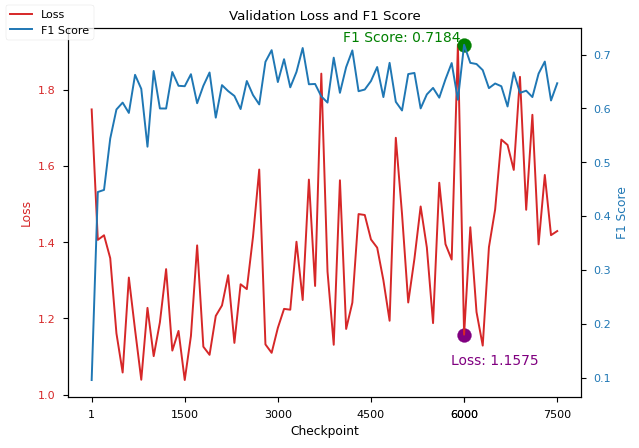

In [ ]:
fig, ax1 = plt.subplots()

# loss on the primary y-axis
color = "tab:red"
ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Loss", color=color)
ax1.plot(checkpoints, valid_loss, color=color, label="Loss")
ax1.tick_params(axis="y", labelcolor=color)

# another axis for f1 score
ax2 = ax1.twinx()

color = "tab:blue"

ax2.plot(checkpoints, valid_f1s, color=color, label="F1 Score")
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylabel("F1 Score", color=color)

# points with the highest f1 score and corresponding loss
max_f1s_index = np.argmax(valid_f1s)
max_f1s = valid_f1s[max_f1s_index]
corresponding_loss = valid_loss[max_f1s_index]

ax2.scatter(checkpoints[max_f1s_index], max_f1s, color="green", marker="o", s=100)
ax1.scatter(
    checkpoints[max_f1s_index], corresponding_loss, color="purple", marker="o", s=100
)


ax2.text(
    checkpoints[max_f1s_index] - 1000,
    max_f1s,
    f"F1 Score: {max_f1s:.4f}",
    ha="center",
    va="bottom",
    color="green",
)
ax1.text(
    checkpoints[max_f1s_index] + 500,
    corresponding_loss - 0.05,
    f"Loss: {corresponding_loss:.4f}",
    ha="center",
    va="top",
    color="purple",
)

ax1.set_xticks(sorted(checkpoints[::15] + [checkpoints[max_f1s_index]]))

plt.tight_layout()
plt.title("Validation Loss and F1 Score")
fig.legend(loc="upper left")
plt.show()

# Test the model with reduced data

Main locations for the right hand: C3, FC1, FC5, CP1, and CP5.

In [ ]:
channels_to_null = {
    "furthest points": ["TP9", "PO9", "PO10", "TP10", "O1", "O2"],
    "right hemisphere": [
        "P4",
        "P8",
        "CP2",
        "CP6",
        "C4",
        "T8",
        "FC2",
        "FC6",
        "F4",
        "F8",
        "Fp2",
    ],
    "remaining": ["Fp1", "F3", "Fz", "Cz", "Pz", "P3", "P7", "T7", "F7", "F3"],
    "hand": ["FC1", "FC5", "CP1", "CP5", "C3"],
}

In [ ]:
restored_state = states[max_f1s_index]

In [ ]:
loss, accuracy, recall, f1 = evaluate_model(restored_state, valid_dataloader)

test_table = defaultdict(list)
test_table["num_nulled_channels"].append(0)
test_table["loss"].append(loss)
test_table["f1"].append(f1)
test_table["nulled_channels"].append([])
test_table["added_channel"].append(None)

In [ ]:
combined_channels = []

for location, channels_to_null_set in channels_to_null.items():
    print(f"{location}: ")
    for channel in tqdm(channels_to_null_set):
        
        current_channels = combined_channels + [channel]
        valid_dataset.add_remove_channels(current_channels)

        valid_dataloader = DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=True
        )

        loss, f1 = evaluate_model(restored_state, valid_dataloader)

        test_table["num_nulled_channels"].append(len(current_channels))
        test_table["loss"].append(loss)
        test_table["f1"].append(f1)
        test_table["nulled_channels"].append(current_channels)
        test_table["added_channel"].append(channel)

        combined_channels.append(channel)

test_table_pd = pd.DataFrame(test_table)

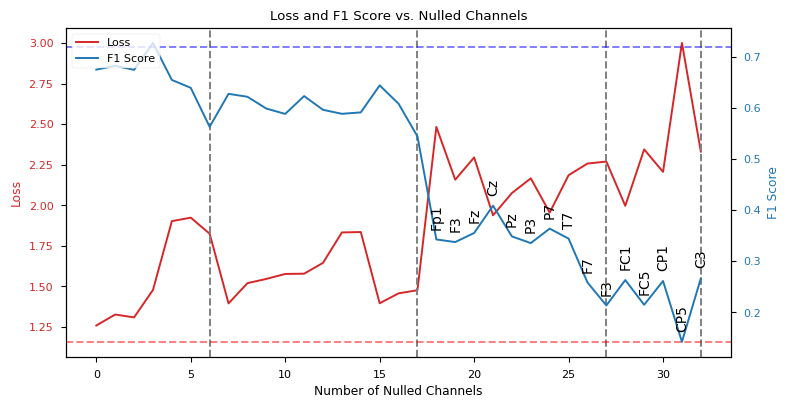

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 4))

num_nulled_channels = test_table["num_nulled_channels"]
losses = test_table["loss"]
f1s = test_table["f1"]
added_channels = test_table["added_channel"]

# loss on the primary y-axis
color = "tab:red"
ax1.set_xlabel("Number of Nulled Channels")
ax1.set_ylabel("Loss", color=color)
ax1.plot(num_nulled_channels, losses, color=color, label="Loss")
ax1.tick_params(axis="y", labelcolor=color)

# a secondary y-axis for f1 score
ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel("F1 Score", color=color)
ax2.plot(num_nulled_channels, f1s, color=color, label="F1 Score")
ax2.tick_params(axis="y", labelcolor=color)

# labels for the added channels
segments = [6, 17, 27, 32]
for i, channel in enumerate(added_channels):
    if channel is not None and i > segments[-3]:
        ax2.text(
            num_nulled_channels[i],
            f1s[i] + 0.02,
            channel,
            ha="center",
            va="bottom",
            rotation=90,
        )

for location in segments:
    ax1.axvline(x=location, color="gray", linestyle="--")

ax2.axhline(y=max_f1s, color="blue", linestyle="--", alpha=0.5)
ax1.axhline(y=corresponding_loss, color="red", linestyle="--", alpha=0.5)


plt.tight_layout()

plt.title("Loss and F1 Score vs. Nulled Channels")
fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax1.transAxes)
plt.show()

# Build an SVM classifier

## Training the SVM classifier

In [ ]:
X, y = [], []

for raw_data, label in tqdm(dataloader):
    # Encode the raw data
    encoded_data = encoder.apply(
        restored_state.params["encoder"], raw_data.numpy(), training=False
    )
    X.extend(
        encoded_data.reshape(encoded_data.shape[0], -1)
    )  # Flatten and extend encoded data
    y.extend(
        np.argmax(label.numpy(), axis=1)
    )  # Get the label index along the class axis

100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


In [ ]:
# for some reason the size of the last list value was smaller
X = np.array(X[:-1])
y = np.array(y[:-1])

In [ ]:
svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X, y)

SVC(kernel='linear')

In [ ]:
y_pred = svm_classifier.predict(X)

In [ ]:
f1 = f1_score(y, y_pred, average="weighted")
print(f"SVM F1 Score: {f1}")

SVM F1 Score: 0.9059522923123479


## Testing the classifier

In [ ]:
# reinstantiating the validation dataset since some channels have been already nulled.
valid_dataset = EEGSignalDataset(valid_eeg, valid_gestures)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
valid_X, valid_y = [], []

for raw_data, label in tqdm(valid_dataloader):
    # Encode the raw data
    encoded_data = encoder.apply(
        restored_state.params["encoder"], raw_data.numpy(), training=False
    )
    valid_X.extend(
        encoded_data.reshape(encoded_data.shape[0], -1)
    )  # Flatten and extend encoded data
    valid_y.extend(
        np.argmax(label.numpy(), axis=1)
    )  # Get the label index along the class axis

100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


In [ ]:
valid_X = np.array(valid_X[:-1])
valid_y = np.array(valid_y[:-1])

In [ ]:
valid_y_pred = svm_classifier.predict(valid_X)

In [ ]:
f1 = f1_score(valid_y, valid_y_pred, average="weighted")
print(f"SVM F1 Score: {f1}")

SVM F1 Score: 0.6557608205603461


## Testing with channels closest to the hand representation on the cortex only

In [ ]:
valid_dataset.add_remove_channels(added_channels[1 : segments[-3]])
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
valid_X, valid_y = [], []

for raw_data, label in tqdm(valid_dataloader):
    # Encode the raw data
    encoded_data = encoder.apply(
        restored_state.params["encoder"], raw_data.numpy(), training=False
    )
    valid_X.extend(
        encoded_data.reshape(encoded_data.shape[0], -1)
    )  # Flatten and extend encoded data
    valid_y.extend(
        np.argmax(label.numpy(), axis=1)
    )  # Get the label index along the class axis

100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


In [ ]:
valid_X = np.array(valid_X[:-1])
valid_y = np.array(valid_y[:-1])

In [ ]:
valid_y_pred = svm_classifier.predict(valid_X)

In [ ]:
f1 = f1_score(valid_y, valid_y_pred, average="weighted")
print(f"SVM F1 Score: {f1}")

SVM F1 Score: 0.5678480018355998
